In [ ]:
# ==========================================
# BAGIAN 1: TRAINING & SAVING
# (Classification Head + Dilation + Dustbin Class)
# ==========================================

import os
import torch
import torch.nn as nn
import numpy as np
import urllib.request
import cv2
import json
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import Dataset, DataLoader, random_split
from torch.optim import AdamW
from torch.optim.lr_scheduler import CosineAnnealingLR
from transformers import CLIPProcessor, CLIPVisionModel
from peft import LoraConfig, get_peft_model
from PIL import Image, ImageOps
from tqdm.auto import tqdm
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# --- KONFIGURASI FINAL ---
class Config:
    MODEL_ID = "openai/clip-vit-base-patch16"
    BATCH_SIZE = 32
    LEARNING_RATE = 1e-4
    EPOCHS = 2
    DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
    LORA_R = 32

    # KATEGORI UTAMA (Yang ingin dikenali)
    TARGET_CATEGORIES = ["cat", "bicycle", "face", "airplane"]

    # KATEGORI SAMPAH (Untuk melatih kelas 'unknown')
    # Kita ambil benda yang bentuknya mirip-mirip tapi beda
    JUNK_SOURCES = ["apple", "tree", "book", "clock", "car", "bus", "truck", "dog"]

    # TOTAL KATEGORI TRAINING
    TRAIN_CLASSES = TARGET_CATEGORIES + ["unknown"]

    LABEL2ID = {v: k for k, v in enumerate(TRAIN_CLASSES)}
    ID2LABEL = {k: v for k, v in enumerate(TRAIN_CLASSES)}

    SAMPLES_PER_CLASS = 4000

print(f"Running on Device: {Config.DEVICE}")
print(f"Labels: {Config.LABEL2ID}")

# --- FUNGSI DOWNLOAD & PREPARE DATA ---
def download_npy(category):
    base_url = "https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/"
    if not os.path.exists("quickdraw_data"): os.makedirs("quickdraw_data")
    filename = f"{category}.npy"
    path = f"quickdraw_data/{filename}"
    if not os.path.exists(path):
        print(f"Downloading {category}...")
        try:
            urllib.request.urlretrieve(base_url + filename, path)
        except:
            print(f"Gagal download {category}")
            return np.array([])
    return np.load(path)

def prepare_datasets():
    full_data = []

    # 1. Ambil Data Target (Cat, Bicycle, etc)
    print("\n--- Loading Target Categories ---")
    for cat in Config.TARGET_CATEGORIES:
        data = download_npy(cat)
        if len(data) > 0:
            data = data[:Config.SAMPLES_PER_CLASS]
            for bitmap in data:
                full_data.append({
                    "label": cat,
                    "label_id": Config.LABEL2ID[cat],
                    "bitmap": bitmap
                })

    # 2. Ambil Data Sampah (Masuk ke keranjang 'unknown')
    print("--- Loading Dustbin (Unknown) Data ---")
    samples_per_junk = Config.SAMPLES_PER_CLASS // len(Config.JUNK_SOURCES)
    for junk in Config.JUNK_SOURCES:
        data = download_npy(junk)
        if len(data) > 0:
            data = data[:samples_per_junk]
            for bitmap in data:
                full_data.append({
                    "label": "unknown", # Label dipukul rata jadi 'unknown'
                    "label_id": Config.LABEL2ID["unknown"],
                    "bitmap": bitmap
                })

    # 3. Data Tes Terpisah (Benar-benar asing, misal: 'car')
    # Ini untuk menguji apakah model benar-benar paham 'unknown'
    test_trap_data = []
    trap_source = download_npy("car") # Kita pakai mobil sebagai jebakan maut
    if len(trap_source) > 0:
        trap_source = trap_source[:200]
        for bitmap in trap_source:
             test_trap_data.append({
                "label": "car (trap)",
                "label_id": -1, # Tidak punya ID
                "bitmap": bitmap
            })

    return full_data, test_trap_data

class QuickDrawDataset(Dataset):
    def __init__(self, data_list, processor):
        self.data = data_list
        self.processor = processor

    def __len__(self): return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]
        # Reshape & Dilation (Penebalan Garis)
        bitmap = item["bitmap"].reshape(28, 28).astype(np.uint8)
        kernel = np.ones((2,2), np.uint8)
        bitmap = cv2.dilate(bitmap, kernel, iterations=1)

        image = Image.fromarray(bitmap)
        image = ImageOps.invert(image).convert("RGB")

        inputs = self.processor(images=image, return_tensors="pt")

        return {
            "pixel_values": inputs["pixel_values"].squeeze(0),
            "labels": torch.tensor(item["label_id"], dtype=torch.long),
            "raw_label": item["label"]
        }

# --- ARSITEKTUR MODEL ---
class CLIPClassifier(nn.Module):
    def __init__(self, backbone, num_classes):
        super().__init__()
        self.backbone = backbone
        # Classification Head
        self.classifier = nn.Linear(backbone.config.hidden_size, num_classes)

    def forward(self, pixel_values, labels=None):
        outputs = self.backbone(pixel_values=pixel_values)
        pooled_output = outputs.pooler_output
        logits = self.classifier(pooled_output)

        loss = None
        if labels is not None:
            loss_fct = nn.CrossEntropyLoss()
            loss = loss_fct(logits, labels)

        return loss, logits

# --- SETUP & TRAINING ---
print("\n--- Setup Data & Model ---")
all_data, trap_data = prepare_datasets()
train_size = int(0.8 * len(all_data))
val_size = len(all_data) - train_size
train_set, val_set = random_split(all_data, [train_size, val_size])

processor = CLIPProcessor.from_pretrained(Config.MODEL_ID)
vision_model = CLIPVisionModel.from_pretrained(Config.MODEL_ID)

# LoRA Setup
peft_config = LoraConfig(r=Config.LORA_R, lora_alpha=Config.LORA_R*2, target_modules=["q_proj", "v_proj", "out_proj", "fc1", "fc2"], lora_dropout=0.1, bias="none")
vision_model = get_peft_model(vision_model, peft_config)
# Unfreeze LayerNorm (Opsional, tapi bagus)
for name, param in vision_model.named_parameters():
    if "layer_norm" in name or "ln_1" in name or "ln_2" in name: param.requires_grad = True

model = CLIPClassifier(vision_model, len(Config.TRAIN_CLASSES)).to(Config.DEVICE)
train_loader = DataLoader(QuickDrawDataset(train_set, processor), batch_size=Config.BATCH_SIZE, shuffle=True)
val_loader = DataLoader(QuickDrawDataset(val_set, processor), batch_size=Config.BATCH_SIZE)

optimizer = AdamW(model.parameters(), lr=Config.LEARNING_RATE)
scheduler = CosineAnnealingLR(optimizer, T_max=Config.EPOCHS)
history = {"train_loss": [], "val_loss": [], "val_acc": []}

print(f"\n--- START TRAINING ({Config.EPOCHS} Epochs) ---")
for epoch in range(Config.EPOCHS):
    model.train()
    train_loss = 0
    for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
        batch = {k: v.to(Config.DEVICE) if hasattr(v, 'to') else v for k, v in batch.items()}
        loss, _ = model(batch['pixel_values'], batch['labels'])
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    scheduler.step()

    # Validation
    model.eval()
    val_loss, correct = 0, 0
    total = 0
    with torch.no_grad():
        for batch in val_loader:
            batch = {k: v.to(Config.DEVICE) if hasattr(v, 'to') else v for k, v in batch.items()}
            loss, logits = model(batch['pixel_values'], batch['labels'])
            val_loss += loss.item()
            preds = torch.argmax(logits, dim=1)
            correct += (preds == batch['labels']).sum().item()
            total += len(batch['labels'])

    avg_train = train_loss / len(train_loader)
    avg_val = val_loss / len(val_loader)
    acc = correct / total

    history["train_loss"].append(avg_train)
    history["val_loss"].append(avg_val)
    history["val_acc"].append(acc)
    print(f" -> Loss: {avg_train:.4f} | Val Loss: {avg_val:.4f} | Acc: {acc:.2%}")

# --- SAVING MODEL ---
print("\n--- MENYIMPAN MODEL ---")
torch.save(model.state_dict(), "quickdraw_final_model.pth")
with open("label_map.json", "w") as f: json.dump(Config.ID2LABEL, f)
print("✅ Model tersimpan: 'quickdraw_final_model.pth'")

Running on Device: cuda
Labels: {'cat': 0, 'bicycle': 1, 'face': 2, 'airplane': 3, 'unknown': 4}

--- Setup Data & Model ---

--- Loading Target Categories ---
--- Loading Dustbin (Unknown) Data ---


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/905 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/599M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/599M [00:00<?, ?B/s]


--- START TRAINING (2 Epochs) ---


Epoch 1:   0%|          | 0/500 [00:00<?, ?it/s]

 -> Loss: 0.2169 | Val Loss: 0.1237 | Acc: 95.85%


Epoch 2:   0%|          | 0/500 [00:00<?, ?it/s]

 -> Loss: 0.0869 | Val Loss: 0.1141 | Acc: 96.00%

--- MENYIMPAN MODEL ---
✅ Model tersimpan: 'quickdraw_final_model.pth'



[INIT] Memuat Model dari File...
✅ Model Siap Diuji!

--- MENGHITUNG STATISTIK MODEL (VALIDATION SET) ---

[LAPORAN KLASIFIKASI DETIL]
              precision    recall  f1-score   support

         cat       0.95      0.94      0.94       762
     bicycle       1.00      0.98      0.99       769
        face       0.97      0.98      0.98       850
    airplane       0.96      0.98      0.97       838
     unknown       0.93      0.92      0.92       781

    accuracy                           0.96      4000
   macro avg       0.96      0.96      0.96      4000
weighted avg       0.96      0.96      0.96      4000



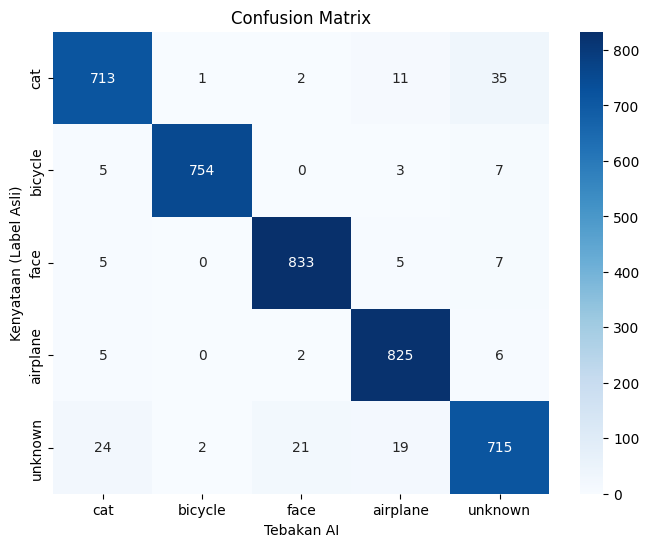


--- MENAMPILKAN 4 CONTOH: TEST 1: GAMBAR TOPIK VALID ---


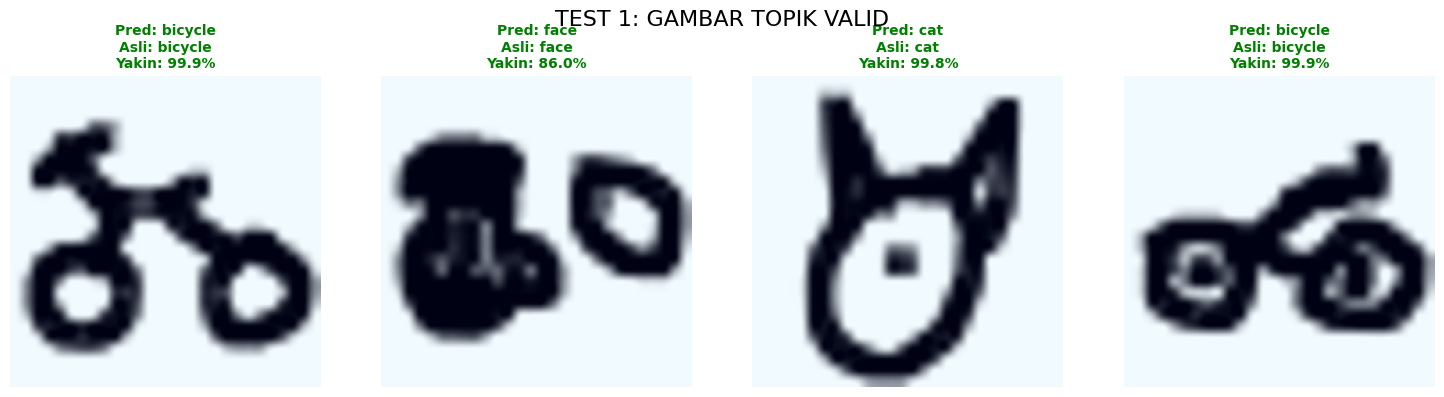


--- MENAMPILKAN 4 CONTOH: TEST 2: GAMBAR JEBAKAN (UNKNOWN) ---


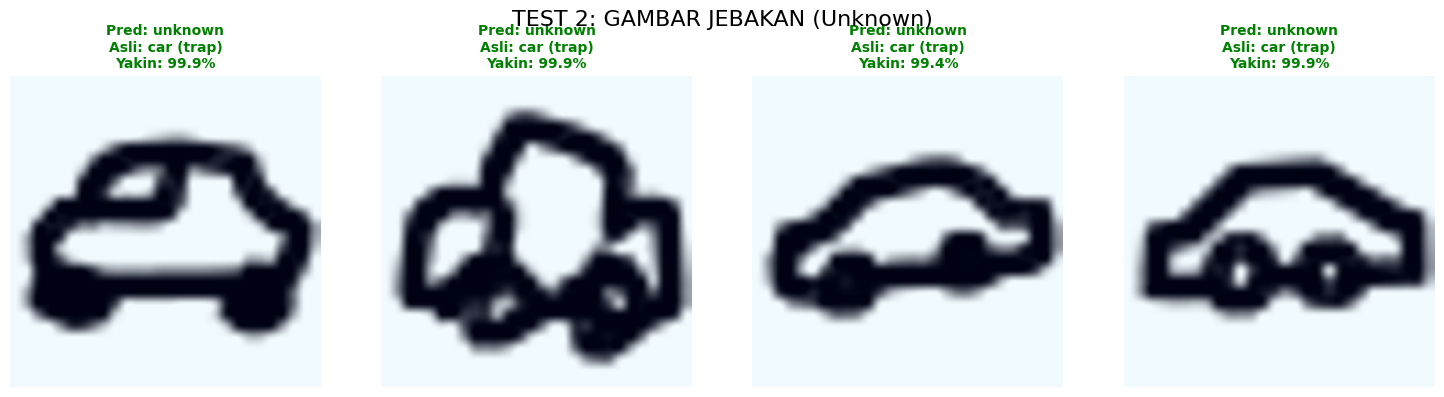

In [ ]:
# ==========================================
# BAGIAN 2: COMPREHENSIVE TESTING & METRICS
# ==========================================

import matplotlib.pyplot as plt
import numpy as np
import torch
import json
import seaborn as sns
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_recall_fscore_support
from transformers import CLIPVisionModel, CLIPProcessor
from peft import LoraConfig, get_peft_model

# --- 1. LOAD KEMBALI MODEL ---
print("\n[INIT] Memuat Model dari File...")
try:
    with open("label_map.json", "r") as f:
        id2label_raw = json.load(f)
        ID2LABEL = {int(k): v for k, v in id2label_raw.items()}
except FileNotFoundError:
    print("⚠️ File label_map.json tidak ditemukan. Menggunakan default.")
    ID2LABEL = {0: 'cat', 1: 'bicycle', 2: 'face', 3: 'airplane', 4: 'unknown'}

# Rebuild Architecture
vision_model = CLIPVisionModel.from_pretrained(Config.MODEL_ID)
peft_config = LoraConfig(r=Config.LORA_R, lora_alpha=Config.LORA_R*2, target_modules=["q_proj", "v_proj", "out_proj", "fc1", "fc2"], lora_dropout=0.1, bias="none")
vision_model = get_peft_model(vision_model, peft_config)

# Re-enable LayerNorm params
for name, param in vision_model.named_parameters():
    if "layer_norm" in name or "ln_1" in name or "ln_2" in name: param.requires_grad = True

model_test = CLIPClassifier(vision_model, len(ID2LABEL))
try:
    model_test.load_state_dict(torch.load("quickdraw_final_model.pth", map_location=Config.DEVICE))
    model_test.to(Config.DEVICE)
    model_test.eval()
    print("✅ Model Siap Diuji!")
except FileNotFoundError:
    print("❌ ERROR: File 'quickdraw_final_model.pth' tidak ditemukan. Lakukan Training (Bagian 1) terlebih dahulu.")

# --- FUNGSI UTAMA: MENGHITUNG METRIK ---
def calculate_metrics(loader):
    y_true, y_pred = [], []

    print("\n--- MENGHITUNG STATISTIK MODEL (VALIDATION SET) ---")
    with torch.no_grad():
        for batch in loader:
            batch = {k: v.to(Config.DEVICE) if hasattr(v, 'to') else v for k, v in batch.items()}
            _, logits = model_test(batch['pixel_values'])
            preds = torch.argmax(logits, dim=1).cpu().numpy()
            y_pred.extend(preds)
            y_true.extend(batch['labels'].cpu().numpy())

    # 1. Classification Report (Precision, Recall, F1)
    target_names = [ID2LABEL[i] for i in range(len(ID2LABEL))]
    print("\n[LAPORAN KLASIFIKASI DETIL]")
    print(classification_report(y_true, y_pred, target_names=target_names))

    # 2. Confusion Matrix Heatmap
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
    plt.title("Confusion Matrix")
    plt.ylabel('Kenyataan (Label Asli)')
    plt.xlabel('Tebakan AI')
    plt.show()

# Jalankan Perhitungan Metrik pada Data Validasi
calculate_metrics(val_loader)


# --- FUNGSI VISUALISASI DENGAN CONFIDENCE SCORE ---
def visualize_predictions(model, loader, title="Visualisasi Prediksi", num_samples=4):
    print(f"\n--- MENAMPILKAN {num_samples} CONTOH: {title.upper()} ---")

    # Ambil data secukupnya
    data_iter = iter(loader)
    images_collected, preds_collected, confs_collected, labels_collected = [], [], [], []

    # Loop sampai dapat jumlah sampel yang diminta
    while len(images_collected) < num_samples:
        try:
            batch = next(data_iter)
            pixel_values = batch['pixel_values'].to(Config.DEVICE)
            labels = batch['labels'].to(Config.DEVICE)

            # Safe Raw Label Lookup
            if 'raw_label' in batch:
                raw_labels = batch['raw_label']
            else:
                raw_labels = [ID2LABEL.get(l.item(), "TRAP_ITEM") for l in labels]

            with torch.no_grad():
                _, logits = model(pixel_values)
                probs = torch.softmax(logits, dim=1) # Ubah ke persen

                # Logic Threshold & Confidence Extraction
                for i in range(len(logits)):
                    if len(images_collected) >= num_samples: break

                    p_idx = torch.argmax(probs[i]).item()
                    conf = probs[i][p_idx].item() # Skor LoRA (Seberapa yakin)
                    p_lbl = ID2LABEL[p_idx]

                    # Logika Threshold 60%
                    if p_lbl != "unknown" and conf < 0.6:
                        p_lbl = "unknown (ragu)"

                    # Simpan data
                    images_collected.append(pixel_values[i].cpu())
                    preds_collected.append(p_lbl)
                    confs_collected.append(conf)

                    true_lbl = raw_labels[i]
                    if hasattr(true_lbl, 'item'): true_lbl = true_lbl.item()
                    labels_collected.append(true_lbl)

        except StopIteration:
            break

    # Plotting Grid
    if len(images_collected) == 0:
        print("Data tidak cukup.")
        return

    cols = num_samples # Tampilkan semua dalam 1 baris (karena cuma 4)
    rows = 1
    plt.figure(figsize=(15, 4))

    for i in range(len(images_collected)):
        plt.subplot(rows, cols, i + 1)

        # Un-normalize image
        img = images_collected[i].permute(1, 2, 0).numpy()
        img = (img - img.min()) / (img.max() - img.min())

        pred_lbl = preds_collected[i]
        true_lbl = str(labels_collected[i])
        conf_score = confs_collected[i]

        # Logika Warna Judul
        if "JEBAKAN" in title:
            # Jebakan dianggap benar jika menjawab unknown
            is_correct = "unknown" in pred_lbl
        else:
            is_correct = (pred_lbl == true_lbl)

        color = 'green' if is_correct else 'red'

        plt.imshow(img)
        # Menampilkan Label + Confidence Score
        plt.title(f"Pred: {pred_lbl}\nAsli: {true_lbl}\nYakin: {conf_score:.1%}", color=color, fontsize=10, fontweight='bold')
        plt.axis('off')

    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()

# --- 1. TES GAMBAR VALID (4 INPUT) ---
# Ambil 4 sampel acak dari data validasi
visualize_predictions(model_test, val_loader, title="TEST 1: GAMBAR TOPIK VALID", num_samples=4)

# --- 2. TES GAMBAR UNKNOWN/JEBAKAN (4 INPUT) ---
# Buat loader khusus untuk trap data (Car)
trap_loader_viz = DataLoader(QuickDrawDataset(trap_data, processor), batch_size=4, shuffle=True)
visualize_predictions(model_test, trap_loader_viz, title="TEST 2: GAMBAR JEBAKAN (Unknown)", num_samples=4)

##Import Library & Dependecies
- torch, nn, optim: Library utama Deep Learning (PyTorch).

- transformers: Untuk memuat model CLIP dari Hugging Face.

- peft: Untuk teknik LoRA (membuat model besar bisa ditraining di GPU kecil).

- cv2 (OpenCV): Untuk memanipulasi gambar (penebalan garis).

- urllib: Untuk mendownload dataset otomatis.

In [ ]:
import os
import torch
import torch.nn as nn
import numpy as np
import urllib.request
import cv2
import json
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import Dataset, DataLoader, random_split
from torch.optim import AdamW
from torch.optim.lr_scheduler import CosineAnnealingLR
from transformers import CLIPProcessor, CLIPVisionModel
from peft import LoraConfig, get_peft_model
from PIL import Image, ImageOps
from tqdm.auto import tqdm
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

##Konfigurasi
Pusat pengaturan (Hyperparameters). Mengubah angka di sini akan mengubah perilaku seluruh training.

  1. MODEL_ID: Menggunakan openai/clip-vit-base-patch16 sebagai otak dasar.

  2. LORA_R = 32: Rank LoRA. Semakin besar angkanya, semakin pintar model mempelajari hal baru, tapi memori yang dipakai lebih besar.

  3. TARGET_CATEGORIES: Benda yang wajib dikenali (Kucing, Sepeda, Wajah, Pesawat).

  4. JUNK_SOURCES: Benda "pengalih" (Apel, Pohon, dll). Benda-benda ini akan dilabeli sebagai "Unknown". Ini penting agar model tidak halu (misal: melihat gambar pohon malah dibilang sepeda).

  5. LABEL2ID: Kamus penerjemah dari Teks ke Angka (misal: "cat" -> 0).

In [ ]:
# --- KONFIGURASI ---
class Config:
    MODEL_ID = "openai/clip-vit-base-patch16"
    BATCH_SIZE = 32
    LEARNING_RATE = 1e-4
    EPOCHS = 2
    DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
    LORA_R = 32

    # KATEGORI UTAMA (Yang ingin dikenali)
    TARGET_CATEGORIES = ["cat", "bicycle", "face", "airplane"]

    # KATEGORI SAMPAH (Untuk melatih kelas 'unknown')
    # Kita ambil benda yang bentuknya mirip-mirip tapi beda
    JUNK_SOURCES = ["apple", "tree", "book", "clock", "car", "bus", "truck", "dog"]

    # TOTAL KATEGORI TRAINING
    TRAIN_CLASSES = TARGET_CATEGORIES + ["unknown"]

    LABEL2ID = {v: k for k, v in enumerate(TRAIN_CLASSES)}
    ID2LABEL = {k: v for k, v in enumerate(TRAIN_CLASSES)}

    SAMPLES_PER_CLASS = 4000

print(f"Running on Device: {Config.DEVICE}")
print(f"Labels: {Config.LABEL2ID}")


##Download data dari google quickdraw
Bagian ini bertugas mengambil bahan mentah dari Google Cloud dan menyajikannya dalam format list yang rapi.

Logika Pembagian Data:

  1. Target Data: Mengambil data kategori utama dan memberi label sesuai namanya.

  2. Dustbin (Unknown) Data: Mengambil data sampah (JUNK_SOURCES), mencampurnya, dan memaksa labelnya menjadi "unknown".

  3. Trap Data (Jebakan): Mengambil data 'car' (mobil) secara terpisah dan tidak diberi ID valid (-1). Data ini tidak dipakai training, tapi disimpan untuk mengetes manual nanti: "Apakah model bingung melihat mobil?" (Seharusnya dia jawab unknown, bukan sepeda).

In [ ]:
def download_npy(category):
    base_url = "https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/"
    if not os.path.exists("quickdraw_data"): os.makedirs("quickdraw_data")
    filename = f"{category}.npy"
    path = f"quickdraw_data/{filename}"
    if not os.path.exists(path):
        print(f"Downloading {category}...")
        try:
            urllib.request.urlretrieve(base_url + filename, path)
        except:
            print(f"Gagal download {category}")
            return np.array([])
    return np.load(path)

def prepare_datasets():
    full_data = []

    # 1. Ambil Data Target (Cat, Bicycle, etc)
    print("\n--- Loading Target Categories ---")
    for cat in Config.TARGET_CATEGORIES:
        data = download_npy(cat)
        if len(data) > 0:
            data = data[:Config.SAMPLES_PER_CLASS]
            for bitmap in data:
                full_data.append({
                    "label": cat,
                    "label_id": Config.LABEL2ID[cat],
                    "bitmap": bitmap
                })

    # 2. Ambil Data Sampah (Masuk ke keranjang 'unknown')
    print("--- Loading Dustbin (Unknown) Data ---")
    samples_per_junk = Config.SAMPLES_PER_CLASS // len(Config.JUNK_SOURCES)
    for junk in Config.JUNK_SOURCES:
        data = download_npy(junk)
        if len(data) > 0:
            data = data[:samples_per_junk]
            for bitmap in data:
                full_data.append({
                    "label": "unknown", # Label dipukul rata jadi 'unknown'
                    "label_id": Config.LABEL2ID["unknown"],
                    "bitmap": bitmap
                })

    # 3. Data Tes Terpisah (Benar-benar asing, misal: 'car')
    # Ini untuk menguji apakah model benar-benar paham 'unknown'
    test_trap_data = []
    trap_source = download_npy("car") # Kita pakai mobil sebagai jebakan maut
    if len(trap_source) > 0:
        trap_source = trap_source[:200]
        for bitmap in trap_source:
             test_trap_data.append({
                "label": "car (trap)",
                "label_id": -1, # Tidak punya ID
                "bitmap": bitmap
            })

    return full_data, test_trap_data


##Dataset Class

Alur Preprocessing:

  1. reshape(28, 28): Mengubah array gepeng menjadi kotak gambar.

  2. cv2.dilate: Menebalkan garis coretan agar lebih jelas terlihat oleh CLIP (yang biasa melihat foto jelas).

  3. ImageOps.invert: Membalik warna (Background Hitam -> Putih) agar mirip kertas gambar biasa.

  4. .convert("RGB"): Mengubah format Hitam-Putih (1 channel) menjadi Berwarna (3 channel) karena CLIP hanya menerima input RGB.

  5. self.processor: Mengubah gambar menjadi Tensor PyTorch dan melakukan normalisasi angka.

In [ ]:
class QuickDrawDataset(Dataset):
    def __init__(self, data_list, processor):
        self.data = data_list
        self.processor = processor

    def __len__(self): return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]
        # Reshape & Dilation (Penebalan Garis)
        bitmap = item["bitmap"].reshape(28, 28).astype(np.uint8)
        kernel = np.ones((2,2), np.uint8)
        bitmap = cv2.dilate(bitmap, kernel, iterations=1)

        image = Image.fromarray(bitmap)
        image = ImageOps.invert(image).convert("RGB")

        inputs = self.processor(images=image, return_tensors="pt")

        return {
            "pixel_values": inputs["pixel_values"].squeeze(0),
            "labels": torch.tensor(item["label_id"], dtype=torch.long),
            "raw_label": item["label"]
        }

##Arsitektur Model

Mendefinisikan bentuk otak buatan yang akan kita rakit.

self.backbone: Menggunakan CLIP Vision Model. Ini bertugas melihat gambar dan mengekstrak fitur (misal: "ada roda", "ada telinga").

self.classifier: Sebuah lapisan Linear sederhana (nn.Linear). Ini bertugas mengambil fitur dari backbone dan menentukan klasifikasinya.

forward:

1. Gambar masuk backbone -> keluar pooled_output (sari pati gambar).

2. Sari pati masuk classifier -> keluar logits (skor prediksi).

3. Jika ada label, hitung loss (seberapa salah tebakannya).

In [ ]:
class CLIPClassifier(nn.Module):
    def __init__(self, backbone, num_classes):
        super().__init__()
        self.backbone = backbone
        # Classification Head
        self.classifier = nn.Linear(backbone.config.hidden_size, num_classes)

    def forward(self, pixel_values, labels=None):
        outputs = self.backbone(pixel_values=pixel_values)
        pooled_output = outputs.pooler_output
        logits = self.classifier(pooled_output)

        loss = None
        if labels is not None:
            loss_fct = nn.CrossEntropyLoss()
            loss = loss_fct(logits, labels)

        return loss, logits

##Setup Training & LoRA

1. Data Splitting: Membagi data menjadi 80% Training (untuk belajar) dan 20% Validation (untuk ujian).

2. Load CLIP: Mendownload otak CLIP dari internet.

3. Inject LoRA (get_peft_model):

    - Daripada mentraining ulang 100% otak CLIP (berat), kita tempelkan adapter kecil (LoRA) di layer-layer tertentu (q_proj, v_proj).

    - Hanya adapter ini yang dilatih. Model asli dibekukan (frozen).

4. Optimizer (AdamW): Algoritma yang bertugas mengupdate kecerdasan model   berdasarkan error yang ditemukan.

In [ ]:
print("\n--- Setup Data & Model ---")
all_data, trap_data = prepare_datasets()
train_size = int(0.8 * len(all_data))
val_size = len(all_data) - train_size
train_set, val_set = random_split(all_data, [train_size, val_size])

processor = CLIPProcessor.from_pretrained(Config.MODEL_ID)
vision_model = CLIPVisionModel.from_pretrained(Config.MODEL_ID)

# LoRA Setup
peft_config = LoraConfig(r=Config.LORA_R, lora_alpha=Config.LORA_R*2, target_modules=["q_proj", "v_proj", "out_proj", "fc1", "fc2"], lora_dropout=0.1, bias="none")
vision_model = get_peft_model(vision_model, peft_config)
# Unfreeze LayerNorm (Opsional, tapi bagus)
for name, param in vision_model.named_parameters():
    if "layer_norm" in name or "ln_1" in name or "ln_2" in name: param.requires_grad = True

model = CLIPClassifier(vision_model, len(Config.TRAIN_CLASSES)).to(Config.DEVICE)
train_loader = DataLoader(QuickDrawDataset(train_set, processor), batch_size=Config.BATCH_SIZE, shuffle=True)
val_loader = DataLoader(QuickDrawDataset(val_set, processor), batch_size=Config.BATCH_SIZE)

optimizer = AdamW(model.parameters(), lr=Config.LEARNING_RATE)
scheduler = CosineAnnealingLR(optimizer, T_max=Config.EPOCHS)
history = {"train_loss": [], "val_loss": [], "val_acc": []}

##Training Loop
A. Fase Training (model.train()):

  - Model melihat sekumpulan gambar (Batch).

  - Model menebak & dihitung salahnya (loss).

  - loss.backward(): Mengkoreksi otak model (Backpropagation).

  - optimizer.step(): Mengupdate bobot model agar lebih pintar.

B. Fase Validasi (model.eval()):

  - Model diuji dengan data yang belum pernah dilihat (Validation Set).

  - Tidak ada koreksi otak (No Grad), hanya menghitung nilai ujian (acc / Akurasi).

  - Hasilnya ditampilkan di layar (Loss dan Acc).

In [ ]:
print(f"\n--- START TRAINING ({Config.EPOCHS} Epochs) ---")
for epoch in range(Config.EPOCHS):
    model.train()
    train_loss = 0
    for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
        batch = {k: v.to(Config.DEVICE) if hasattr(v, 'to') else v for k, v in batch.items()}
        loss, _ = model(batch['pixel_values'], batch['labels'])
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    scheduler.step()

    # Validation
    model.eval()
    val_loss, correct = 0, 0
    total = 0
    with torch.no_grad():
        for batch in val_loader:
            batch = {k: v.to(Config.DEVICE) if hasattr(v, 'to') else v for k, v in batch.items()}
            loss, logits = model(batch['pixel_values'], batch['labels'])
            val_loss += loss.item()
            preds = torch.argmax(logits, dim=1)
            correct += (preds == batch['labels']).sum().item()
            total += len(batch['labels'])

    avg_train = train_loss / len(train_loader)
    avg_val = val_loss / len(val_loader)
    acc = correct / total

    history["train_loss"].append(avg_train)
    history["val_loss"].append(avg_val)
    history["val_acc"].append(acc)
    print(f" -> Loss: {avg_train:.4f} | Val Loss: {avg_val:.4f} | Acc: {acc:.2%}")


##Saving Model


In [ ]:
# --- SAVING MODEL ---
print("\n--- MENYIMPAN MODEL ---")
torch.save(model.state_dict(), "quickdraw_final_model.pth")
with open("label_map.json", "w") as f: json.dump(Config.ID2LABEL, f)
print("✅ Model tersimpan: 'quickdraw_final_model.pth'")

##TESTING PHASE

Bagian ini bertujuan untuk menguji kecerdasan model yang telah dilatih. Kita tidak lagi melakukan training (belajar), melainkan inference (ujian). Kita akan memuat "otak" yang sudah disimpan, lalu mengujinya dengan soal-soal baru dan soal jebakan.

##Memuat Model

Sebelum menguji, kita harus menyusun ulang "tubuh" robotnya agar sama persis dengan saat latihan, baru kemudian kita masukkan "ingatan" (weights) yang sudah disimpan.

1. Load Label Map (label_map.json): Memuat kamus penerjemah ID ke Teks. Tanpa ini, model hanya mengeluarkan angka 0, 1, 2 tanpa arti.

2. Rebuild Architecture:

    - Kita memanggil CLIPVisionModel lagi.

    - Kita pasang ulang adapter LoRA (LoraConfig). Konfigurasi harus sama persis dengan saat training (rank r=32, target modules, dll). Jika beda, struktur model akan rusak.

3. Load Weights (.pth): Mengisi struktur model dengan bobot yang sudah dilatih dari file quickdraw_final_model.pth.

4. model.eval(): Mode Evaluasi. Ini mematikan fitur-fitur training (seperti Dropout) agar hasil prediksi stabil dan konsisten.

In [ ]:
# --- 1. LOAD KEMBALI MODEL ---
print("\n[INIT] Memuat Model dari File...")
try:
    with open("label_map.json", "r") as f:
        id2label_raw = json.load(f)
        ID2LABEL = {int(k): v for k, v in id2label_raw.items()}
except FileNotFoundError:
    print("⚠️ File label_map.json tidak ditemukan. Menggunakan default.")
    ID2LABEL = {0: 'cat', 1: 'bicycle', 2: 'face', 3: 'airplane', 4: 'unknown'}

# Rebuild Architecture
vision_model = CLIPVisionModel.from_pretrained(Config.MODEL_ID)
peft_config = LoraConfig(r=Config.LORA_R, lora_alpha=Config.LORA_R*2, target_modules=["q_proj", "v_proj", "out_proj", "fc1", "fc2"], lora_dropout=0.1, bias="none")
vision_model = get_peft_model(vision_model, peft_config)

# Re-enable LayerNorm params
for name, param in vision_model.named_parameters():
    if "layer_norm" in name or "ln_1" in name or "ln_2" in name: param.requires_grad = True

model_test = CLIPClassifier(vision_model, len(ID2LABEL))
try:
    model_test.load_state_dict(torch.load("quickdraw_final_model.pth", map_location=Config.DEVICE))
    model_test.to(Config.DEVICE)
    model_test.eval()
    print("✅ Model Siap Diuji!")
except FileNotFoundError:
    print("❌ ERROR: File 'quickdraw_final_model.pth' tidak ditemukan. Lakukan Training (Bagian 1) terlebih dahulu.")


##Menghitung Metrik Statistik

Fungsi ini memberikan laporan kinerja secara matematis menggunakan data validasi.

- torch.no_grad(): Memerintahkan PyTorch untuk tidak menghitung gradien. Ini menghemat memori RAM/VRAM secara drastis karena kita hanya memprediksi, bukan belajar.

- Classification Report: Memberikan nilai rapor model:

  - Precision: Seberapa akurat saat model menebak "Kucing"? (Sedikit salah tebak).

  - Recall: Seberapa banyak "Kucing" asli yang berhasil ditemukan? (Sedikit yang terlewat).

  - F1-Score: Nilai rata-rata harmonis antara Precision dan Recall.

- Confusion Matrix:

  - Visualisasi kotak-kotak (Heatmap).

  - Kita bisa melihat: "Apakah model sering tertukar antara 'Wajah' dan 'Apel'?" atau "Apakah benda aneh (Unknown) sering dikira 'Sepeda'?"

In [ ]:
# --- FUNGSI UTAMA: MENGHITUNG METRIK ---
def calculate_metrics(loader):
    y_true, y_pred = [], []

    print("\n--- MENGHITUNG STATISTIK MODEL (VALIDATION SET) ---")
    with torch.no_grad():
        for batch in loader:
            batch = {k: v.to(Config.DEVICE) if hasattr(v, 'to') else v for k, v in batch.items()}
            _, logits = model_test(batch['pixel_values'])
            preds = torch.argmax(logits, dim=1).cpu().numpy()
            y_pred.extend(preds)
            y_true.extend(batch['labels'].cpu().numpy())

    # 1. Classification Report (Precision, Recall, F1)
    target_names = [ID2LABEL[i] for i in range(len(ID2LABEL))]
    print("\n[LAPORAN KLASIFIKASI DETIL]")
    print(classification_report(y_true, y_pred, target_names=target_names))

    # 2. Confusion Matrix Heatmap
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
    plt.title("Confusion Matrix")
    plt.ylabel('Kenyataan (Label Asli)')
    plt.xlabel('Tebakan AI')
    plt.show()

# Jalankan Perhitungan Metrik pada Data Validasi
calculate_metrics(val_loader)


##Visualisasi & Logika Confidence
Fungsi ini mensimulasikan penggunaan aplikasi nyata. Kita menampilkan gambar beserta persentase keyakinan model.

A. Probabilitas (torch.softmax): Output mentah model (logits) berupa angka acak (misal: 2.5, -0.1). softmax mengubahnya menjadi persentase total 100% (misal: 80%, 5%, 15%).

B. Logika Threshold (Ambang Batas): Ini adalah fitur keamanan (Safety Guardrail).

if p_lbl != "unknown" and conf < 0.6:p_lbl = "unknown (ragu)"

  - Logika: Jika model menebak sebuah benda (misal "Kucing"), TAPI tingkat keyakinannya di bawah 60% (0.6), maka sistem akan memaksa jawabannya menjadi "Unknown (ragu)".

  - Tujuan: Mencegah model sok tahu. Lebih baik model bilang "tidak tahu" daripada salah menebak dengan ragu-ragu.

C. Visualisasi:

Mengembalikan warna gambar dari normalisasi tensor ke gambar yang bisa dilihat mata.

Memberikan judul berwarna:

- Hijau: Tebakan benar.

- Merah: Tebakan salah.

In [ ]:
# --- FUNGSI VISUALISASI DENGAN CONFIDENCE SCORE ---
def visualize_predictions(model, loader, title="Visualisasi Prediksi", num_samples=4):
    print(f"\n--- MENAMPILKAN {num_samples} CONTOH: {title.upper()} ---")

    # Ambil data secukupnya
    data_iter = iter(loader)
    images_collected, preds_collected, confs_collected, labels_collected = [], [], [], []

    # Loop sampai dapat jumlah sampel yang diminta
    while len(images_collected) < num_samples:
        try:
            batch = next(data_iter)
            pixel_values = batch['pixel_values'].to(Config.DEVICE)
            labels = batch['labels'].to(Config.DEVICE)

            # Safe Raw Label Lookup
            if 'raw_label' in batch:
                raw_labels = batch['raw_label']
            else:
                raw_labels = [ID2LABEL.get(l.item(), "TRAP_ITEM") for l in labels]

            with torch.no_grad():
                _, logits = model(pixel_values)
                probs = torch.softmax(logits, dim=1) # Ubah ke persen

                # Logic Threshold & Confidence Extraction
                for i in range(len(logits)):
                    if len(images_collected) >= num_samples: break

                    p_idx = torch.argmax(probs[i]).item()
                    conf = probs[i][p_idx].item() # Skor LoRA (Seberapa yakin)
                    p_lbl = ID2LABEL[p_idx]

                    # Logika Threshold 60%
                    if p_lbl != "unknown" and conf < 0.6:
                        p_lbl = "unknown (ragu)"

                    # Simpan data
                    images_collected.append(pixel_values[i].cpu())
                    preds_collected.append(p_lbl)
                    confs_collected.append(conf)

                    true_lbl = raw_labels[i]
                    if hasattr(true_lbl, 'item'): true_lbl = true_lbl.item()
                    labels_collected.append(true_lbl)

        except StopIteration:
            break

    # Plotting Grid
    if len(images_collected) == 0:
        print("Data tidak cukup.")
        return

    cols = num_samples # Tampilkan semua dalam 1 baris (karena cuma 4)
    rows = 1
    plt.figure(figsize=(15, 4))

    for i in range(len(images_collected)):
        plt.subplot(rows, cols, i + 1)

        # Un-normalize image
        img = images_collected[i].permute(1, 2, 0).numpy()
        img = (img - img.min()) / (img.max() - img.min())

        pred_lbl = preds_collected[i]
        true_lbl = str(labels_collected[i])
        conf_score = confs_collected[i]

        # Logika Warna Judul
        if "JEBAKAN" in title:
            # Jebakan dianggap benar jika menjawab unknown
            is_correct = "unknown" in pred_lbl
        else:
            is_correct = (pred_lbl == true_lbl)

        color = 'green' if is_correct else 'red'

        plt.imshow(img)
        # Menampilkan Label + Confidence Score
        plt.title(f"Pred: {pred_lbl}\nAsli: {true_lbl}\nYakin: {conf_score:.1%}", color=color, fontsize=10, fontweight='bold')
        plt.axis('off')

    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()


##Eksekusi Pengujian
Kita melakukan dua jenis tes visual:

Test 1: Gambar Topik Valid

- Mengambil sampel dari data Validasi (Kucing, Wajah, Pesawat, dll).

- Tujuannya melihat apakah model mengenali benda yang sudah dipelajarinya.

Test 2: Gambar Jebakan (Trap Test)

- Menggunakan trap_loader yang berisi gambar Mobil (Car).

- Model tidak pernah diajarkan tentang mobil.

- Harapan: Model harusnya bingung.

  - Idealnya dia menjawab "Unknown".

  - Atau dia menebak sesuatu (misal "Airplane") tapi dengan confidence score rendah (< 60%), sehingga terkena filter threshold kita.

- Jika model menjawab "Airplane" dengan keyakinan 99% pada gambar mobil, berarti model mengalami overfitting atau gagal membedakan fitur.

In [ ]:
# --- 1. TES GAMBAR VALID (4 INPUT) ---
# Ambil 4 sampel acak dari data validasi
visualize_predictions(model_test, val_loader, title="TEST 1: GAMBAR TOPIK VALID", num_samples=4)

# --- 2. TES GAMBAR UNKNOWN/JEBAKAN (4 INPUT) ---
# Buat loader khusus untuk trap data (Car)
trap_loader_viz = DataLoader(QuickDrawDataset(trap_data, processor), batch_size=4, shuffle=True)
visualize_predictions(model_test, trap_loader_viz, title="TEST 2: GAMBAR JEBAKAN (Unknown)", num_samples=4)